# Gradient Boosting Machines for Wine Points Predictions

Wine Spectator's 100-Point Scale

95-100 Classic: a great wine.

90-94 Outstanding: a wine of superior character and style.

85-89 Very good: a wine with special qualities.

80-84 Good: a solid, well-made wine.

75-79 Mediocre: a drinkable wine that may have minor flaws.

50-74 Not recommended.

In [2]:
!pip install xgboost

    100% |████████████████████████████████| 114.0MB 488kB/s 
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install graphviz

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import RegexpTokenizer
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
#Load data
wine = pd.read_csv('data/winemag-data_first150k.csv', index_col=0, encoding="utf-8")
wine.dropna(subset=["price", "points"], inplace=True)
wine.reset_index(inplace=True, drop=True)
wine = wine[['description', 'price', 'points']]
print(wine.shape)
wine.sample(3)

(137235, 3)


,description,price,points
73391,The round mouthfeel is balanced by medium acid...,17.0,87
104441,"At 2.3% residual sugar, this is nicely balance...",10.0,86
126415,You'll find strong flavors of grilled blackber...,24.0,85


# Feature Engineering

In [5]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

wine["description"] = wine["description"].str.replace('\d+', '')
wine["description"] = wine.description.apply(func=remove_punctuation)
wine["description"] = wine.description.apply(func=make_lower_case)

In [10]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=5)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(wine.description)
lsa_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 5))
collist = ["latent_description_" + s for s in collist]
lsa_features.columns = collist
lsa_features.head()

,latent_description_0,latent_description_1,latent_description_2,latent_description_3,latent_description_4
0,0.120579,-0.038306,-0.005802,-0.025517,-0.018458
1,0.130181,-0.041064,0.014711,-0.014055,0.043265
2,0.077164,0.046829,-0.016736,-0.006819,0.021356
3,0.138889,-0.091832,0.032422,-0.004546,0.065667
4,0.085370,-0.002814,-0.077347,-0.102092,-0.016995


# XGBoost Classification

In [14]:
#Make atest train split
X = pd.concat([lsa_features, wine["price"]], axis=1)
y = wine["points"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Format data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#Set xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 10

#Train model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	train-mae:2.05412
Will train until train-mae hasn't improved in 10 rounds.
[1]	train-mae:1.96549
[2]	train-mae:1.93125
[3]	train-mae:1.91672
[4]	train-mae:1.89778
[5]	train-mae:1.87918
[6]	train-mae:1.86159
[7]	train-mae:1.8531
[8]	train-mae:1.84253
[9]	train-mae:1.83785


In [21]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

mean_ae = np.round(mean_absolute_error(y_true=pred["points"], y_pred=pred["prediction"]),2)
median_ae = np.round(median_absolute_error(y_true=pred["points"], y_pred=pred["prediction"]),2)
print ("Mean Absolute Error: {} points".format(mean_ae))

Mean Absolute Error: 1.84 points


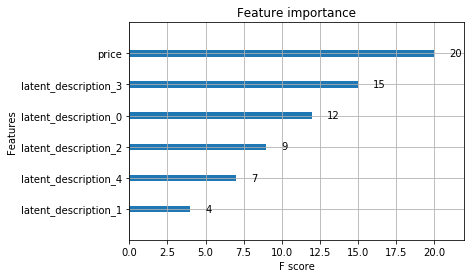

In [23]:
xgb.plot_importance(bst,max_num_features=15)

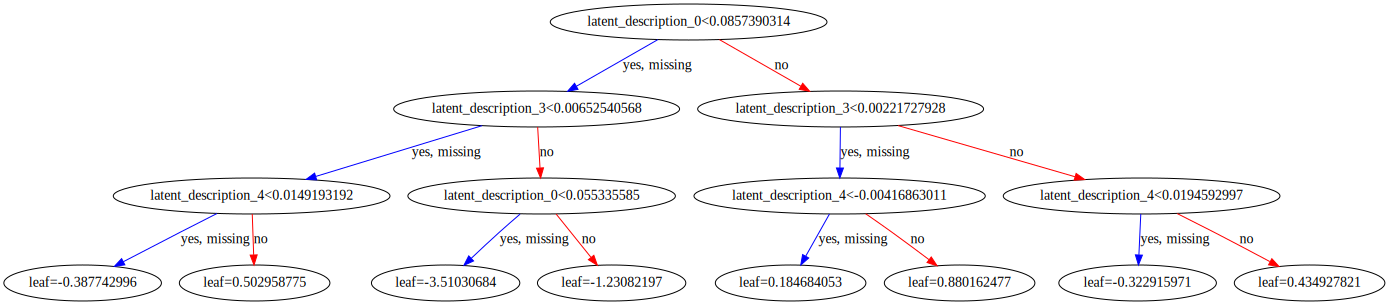

In [24]:
xgb.to_graphviz(bst, num_trees=1)